In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import confusion_matrix, roc_curve, auc
import joblib
import os
import sys, traceback
sys.path.append("//den3s1emcha02-clients.isilon.davita.corp/Nova/A-D/Data_Science/EDA")
# Homegrown Modules #
from model_val_tools import matrix_metrix, sens_ppv

In [3]:
def plot_bar_chart(df, quantile_var, y_true, title_prefix='High Utilizer Rate', imagepath='../images/myimage.jpg'):
    fig_name = 'fig'+y_true
    ax_name = 'ax'+y_true
    if len(df[quantile_var].unique()) == 10:
        x_var_label = 'Decile'
    elif len(df[quantile_var].unique()) == 20:
        x_var_label = 'Ventile'
    else:
        x_var_label = 'Quantile'
    if df[quantile_var].min() == 1:
        add1 = 0
    else:
        add1 = 1
    fig_name = plt.figure(figsize=(12,6))
    ax_name = fig_name.add_subplot(111)
    ax_name.set_title(title_prefix+' by '+x_var_label)
    ax_name.bar(df.groupby(quantile_var)[y_true].mean().index + add1, df.groupby(quantile_var)[y_true].mean()*100)
    mean_rate = df[y_true].mean() *100
    num_quant = (df[quantile_var].unique().shape[0])
    ax_name.plot([.5, num_quant+.5], [mean_rate, mean_rate], '-', lw=3, color='darkorange')  ## from x1,y1 to x2,y2 would be [x1, x2], [y1, y2]
    ax_name.text(.5, (mean_rate+0.3), 'population rate')
    ax_name.set_xticks((df.groupby(quantile_var)[y_true].mean().index + add1))
    ax_name.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax_name.set_ylabel(title_prefix)
    ax_name.set_xlabel('Risk '+x_var_label)
    #if os.path.exists(imagepath):
    #    print('Image already exists. Overwrite (y/n)?')
    #    x = input()
    #else: 
    #    x = 'y'
    #if x == 'y':
    #    fig_name.savefig(imagepath, dpi=300, optimize=True, bbox_inches='tight', pad_inches=0)

def plot_precision_recall_curve(y_true, y_pred_proba, plot_mins_tf=False,
	min_precision=.4, min_recall=.4,
	 title='Precision, Recall by Model Threshold',
	 imagepath='../images/precision_recall_curve.jpg'):
    from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
    proffig = plt.figure(figsize=(8,6))
    ax1 = proffig.add_subplot(111)
    if plot_mins_tf:
        ax1.plot([0,1],[min_precision,min_precision], color='black') ## from x1,y1 to x2,y2 would be [x1, x2], [y1, y2]
        ax1.plot([min_recall,min_recall],[0,1], color='black')
        rect_patch = plt.Rectangle((min_recall, min_precision), (1-min_recall), (1-min_precision), alpha=.2, color='green')
        ax1.add_patch(rect_patch)
        ax1.text(.6, .9, 'Desired Precision, Recall', color='darkgreen')
        ax1.text(min_recall+.01, 0, 'Min Recall = {}'.format(min_recall))
        ax1.text(0, min_precision-.05, 'Min Precision = {}'.format(min_precision))
    # ax1.plot([1,0],[0,0], c='black')
    # profy = max(profs)
    # profx = float(profthresh[(np.where(max(profs) == profs)[0])])
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba, pos_label=None, sample_weight=None)
    auprc = average_precision_score(y_true, y_pred_proba)
    ax1.set_title(title)
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Recall')
    # ax1.set_xlim([xmin,xmax])
    # ax1.set_ylim([ymin,ymax])
    ax1.plot(recall, precision, color='blue', label="AUPRC = {0:0.3f}".format(auprc))
    # ax1.plot(profx, profy, 'ro', label='Max of ${0:.2f} at threshold of {1}'.format(profy, profx))
    ax1.legend()

def plotroc(TPR, FPR):
    from sklearn.metrics import auc
    roc_auc = auc(TPR, FPR)
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(TPR, FPR, color='darkorange',
             lw=lw, label="ROC curve area = {0:0.4f}".format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# n-size, mean age (SD), n/% per CKD stage, n/% female, n/% hospitalized
# df, [id, age, ckd stage, gender, outcome]
def pop_dems(df, id, age, ckd_stg, gender, outcome):
    """given a pandas dataframe and column names in quotes representing 
        patient ID, age, CKD stage, Gender, and outcome, return a table
        of population demographics relative to the outcome a predictive 
        model is trying to predict.
    """
    pop_n = df[id].count()
    avg_age = round(df[age].mean(), 1)
    sd_age = round(df[age].std(), 1)

    ckd_df = df.groupby(ckd_stg).agg({ckd_stg: 'count'})
    ckd_df.rename(columns={ckd_stg: 'stg_count'}, inplace=True)
    ckd_df['stg_pct'] = round((ckd_df['stg_count'] / ckd_df['stg_count'].sum()) * 100, 1)

    sex_df = df.groupby(gender).agg({gender: 'count'})
    sex_df.rename(columns={gender: 'gender_count'}, inplace=True)
    sex_df['gender_pct'] = round((sex_df['gender_count'] / sex_df['gender_count'].sum()) * 100, 1)

    hsp_df = df.groupby(outcome).agg({outcome: 'count'})
    hsp_df.rename(columns={outcome: 'outcome_count'}, inplace=True)
    hsp_df['outcome_pct'] = round((hsp_df['outcome_count'] / hsp_df['outcome_count'].sum()) * 100, 1)
    if outcome == 'TRANS_OUTCOME':
        event = 'Transitioned'
    elif outcome == 'HOSP_OUTCOME':
        event = 'Hospitalized'


    pt_chars = [['Population Size', str(pop_n)], 
                ['Age, years, mean (SD)', f'{avg_age} ({sd_age})'], 
                ['CKD Stage, n (%)', ''], 
                ['3', f"{ckd_df.loc[3.0, 'stg_count']} ({ckd_df.loc[3.0, 'stg_pct']}%)"],
                ['4', f"{ckd_df.loc[4.0, 'stg_count']} ({ckd_df.loc[4.0, 'stg_pct']}%)"], 
                ['5', f"{ckd_df.loc[5.0, 'stg_count']} ({ckd_df.loc[5.0, 'stg_pct']}%)"], 
                ['Female Sex, n (%)', f"{sex_df.loc['Female', 'gender_count']} ({sex_df.loc['Female', 'gender_pct']}%)"], 
                [f'{event}, n (%)', f"{hsp_df.loc[1, 'outcome_count']} ({hsp_df.loc[1, 'outcome_pct']}%)"]
                ]
    pt_chars = pd.DataFrame(pt_chars)
    return pt_chars

# Transition Model

##### Load data

In [64]:
# trans
df1 = pd.read_csv("//den3s1emcha02-clients.isilon.davita.corp/Nova/A-D/Data_Science/dcr_models/ckd_trans_model_20210818/reports/IUH_validation_CKD_TRANS_MA_CKD345_20221121.csv")

In [65]:
df1.head()

SUBSCR_ID PAYOR_ABBR SCORING_DATE ESKD_TRANSITION_DT  GENDER  q2CKDStage  \
0     319988        IUH   2021-01-01                  0    Male         3.0   
1      27022        IUH   2021-01-01                  0    Male         3.0   
2     123439        IUH   2021-01-01                  0    Male         4.0   
3     209215        IUH   2021-01-01                  0  Female         3.0   
4     890335        IUH   2021-01-01                  0    Male         3.0   

    Age  ATTR_ON_SCORE_DT  Death_Dt  RISK_SCORE  RISK_GROUP  
0  88.0               1.0       NaN    0.007369         2.0  
1  77.0               1.0       NaN    0.011042         7.0  
2  74.0               1.0       NaN    0.192517        20.0  
3  81.0               1.0       NaN    0.009106         4.0  
4  71.0               1.0       NaN    0.014508        11.0

##### Cleaning outcome variables and exclusion variables

In [66]:
df1.loc[df1['ESKD_TRANSITION_DT'] == '0', 'ESKD_TRANSITION_DT'] = np.NaN
df1.loc[df1['Death_Dt'] == '0', 'Death_Dt'] = np.NaN

In [67]:
df1['SCORING_DATE'] = pd.to_datetime(df1['SCORING_DATE'])
df1['ESKD_TRANSITION_DT'] = pd.to_datetime(df1['ESKD_TRANSITION_DT'])
df1['Death_Dt'] = pd.to_datetime(df1['Death_Dt'])

##### risk window end dates

In [68]:
df1['TRANS_RISK_END'] = df1.apply(lambda x: x['SCORING_DATE'] + pd.DateOffset(months = 18), axis=1)
df1.loc[df1['ESKD_TRANSITION_DT'] >= df1['TRANS_RISK_END'], 'ESKD_TRANSITION_DT'] = np.NaN

##### making outcomes binary variables

In [69]:
# translate outcomes into binary 1/0 variables
df1['TRANS_OUTCOME'] = df1['ESKD_TRANSITION_DT'].notna()*1

##### cleaning data - removing excluded patient records
###### patients who transition or die prior to scoring, are not CKD 45 at least 3 months prior to scoring, or aren't attributed on the scoring date

In [70]:
tdf = df1[((df1['ESKD_TRANSITION_DT'] > df1["SCORING_DATE"]) | (df1['ESKD_TRANSITION_DT'].isna())) 
        & ((df1['Death_Dt'] > df1["SCORING_DATE"]) | (df1['Death_Dt'].isna())) 
        & (df1["q2CKDStage"] >= 3) 
        & (df1['ATTR_ON_SCORE_DT'] == 1)
        ]
print(tdf.shape[0])

1225


In [71]:
tdf['TRANS_OUTCOME'].sum()

14

##### Patient Characteristics

In [72]:
pop_dems(tdf, 'SUBSCR_ID', 'Age', 'q2CKDStage', 'GENDER', 'TRANS_OUTCOME')

0            1
0        Population Size         1225
1  Age, years, mean (SD)   78.1 (7.8)
2       CKD Stage, n (%)             
3                      3  906 (74.0%)
4                      4  295 (24.1%)
5                      5    24 (2.0%)
6      Female Sex, n (%)  615 (50.2%)
7    Transitioned, n (%)    14 (1.1%)

In [73]:
t_thresh = sens_ppv(tdf['TRANS_OUTCOME'], tdf['RISK_SCORE']).sort_values("ventile", ascending=False)
print(f'\nImported validation data with {tdf.shape[0]} predictions.\n'
        f'Transition Model Execution Statistics: \n\n {t_thresh.to_string(index=False)}')


Imported validation data with 1225 predictions.
Transition Model Execution Statistics: 

 ventile % of pop  sensitivity    PPV  Lift  score_threshold  target_freq
     20     5.0%       0.0000 0.0000  0.00         0.098968            0
     19    10.0%       0.8571 0.0976  8.54         0.068980           12
     18    15.0%       0.8571 0.0652  5.70         0.056873            0
     17    20.0%       0.8571 0.0490  4.29         0.043794            0
     16    25.0%       1.0000 0.0458  4.01         0.033775            2
     15    30.0%       1.0000 0.0380  3.32         0.026272            0
     14    35.0%       1.0000 0.0326  2.85         0.019544            0
     13    40.0%       1.0000 0.0286  2.50         0.016779            0
     12    45.0%       1.0000 0.0254  2.22         0.015324            0
     11    50.0%       1.0000 0.0229  2.00         0.014090            0
     10    55.0%       1.0000 0.0208  1.82         0.013044            0
      9    60.0%       1.0000 0.0

In [74]:
tdf['TRANS_RISK_GROUP_DETAIL'] = pd.qcut(tdf['RISK_SCORE'].rank(method='first'), 20, labels=False, duplicates='drop')+1
#tdf.groupby(["PAYOR_ABBR"])["RISK_SCORE"].transform(lambda x: pd.qcut(x.rank(method='first'), 20, labels = False))+1

c:\Users\ryaberry\AppData\Local\Continuum\anaconda3\envs\dcr_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


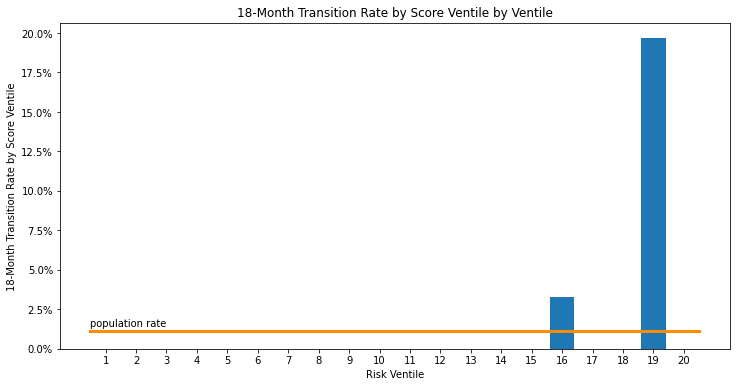

In [75]:
plot_bar_chart(tdf, 'TRANS_RISK_GROUP_DETAIL', 'TRANS_OUTCOME', title_prefix='18-Month Transition Rate by Score Ventile')

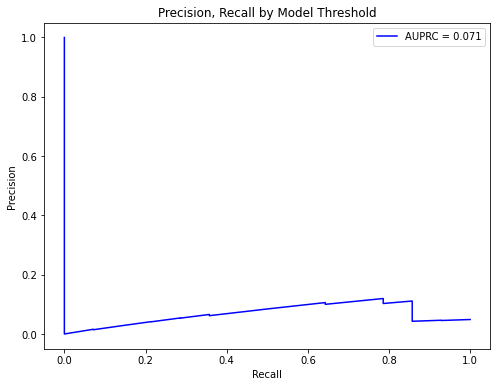

In [76]:
plot_precision_recall_curve(tdf['TRANS_OUTCOME'], tdf['RISK_SCORE'])

In [77]:
TPRi, FPRi, thresholds_i = roc_curve(tdf['TRANS_OUTCOME'], tdf['RISK_SCORE'], pos_label=None, sample_weight=None, drop_intermediate=True)
plotroc(TPRi, FPRi)

In [78]:
tdf['TRANS_OUTCOME'].sum()/tdf.shape[0]

0.011428571428571429

# Hospitalization Model

##### Load data

In [81]:
# hosp
df2 = pd.read_csv("//den3s1emcha02-clients.isilon.davita.corp/Nova/A-D/Data_Science/dcr_models/ckd_hosp_model_20210820/reports/IUH_validation_CKD_HOSP_MA_CKD345_20221118.csv")

In [82]:
df2.head()

SUBSCR_ID PAYOR_ABBR SCORING_DATE HOSPITAL_ADMISSION_DT ESKD_TRANSITION_DT  \
0     252228        IUH   2021-01-01            2021-12-14                  0   
1      71334        IUH   2021-01-01                     0                  0   
2     659385        IUH   2021-01-01                     0                  0   
3     343993        IUH   2021-01-01            2021-11-05                  0   
4      69623        IUH   2021-01-01            2021-10-22                  0   

   GENDER  q2CKDStage   Age  ATTR_ON_SCORE_DT  Death_Dt  RISK_SCORE  \
0  Female         0.0  74.0               1.0       NaN    0.478467   
1  Female         0.0  75.0               1.0       NaN    0.497957   
2    Male         3.0  85.0               1.0       NaN    0.510187   
3    Male         3.0  91.0               1.0       NaN    0.506635   
4    Male         3.0  90.0               1.0       NaN    0.482415   

   RISK_GROUP  
0          10  
1          18  
2          20  
3          19  
4          12

##### Cleaning outcome variables and exclusion variables

In [83]:
df2.loc[df2['HOSPITAL_ADMISSION_DT'] == '0', 'HOSPITAL_ADMISSION_DT'] = np.NaN
df2.loc[df2['ESKD_TRANSITION_DT'] == '0', 'ESKD_TRANSITION_DT'] = np.NaN
df2.loc[df2['Death_Dt'] == '0', 'Death_Dt'] = np.NaN

In [84]:
df2['SCORING_DATE'] = pd.to_datetime(df2['SCORING_DATE'])
df2['ESKD_TRANSITION_DT'] = pd.to_datetime(df2['ESKD_TRANSITION_DT'])
df2['HOSPITAL_ADMISSION_DT'] = pd.to_datetime(df2['HOSPITAL_ADMISSION_DT'])
df2['Death_Dt'] = pd.to_datetime(df2['Death_Dt'])

##### risk window end dates

In [85]:
df2['HOSP_RISK_END'] = df2.apply(lambda x: x['SCORING_DATE'] + pd.DateOffset(months = 3), axis=1)
df2.loc[df2['HOSPITAL_ADMISSION_DT'] >= df2['HOSP_RISK_END'], 'HOSPITAL_ADMISSION_DT'] = np.NaN

df2['TRANS_RISK_END'] = df2.apply(lambda x: x['SCORING_DATE'] + pd.DateOffset(months = 18), axis=1)
df2.loc[df2['ESKD_TRANSITION_DT'] >= df2['TRANS_RISK_END'], 'ESKD_TRANSITION_DT'] = np.NaN

##### making outcomes binary variables

In [86]:
df2['HOSP_OUTCOME'] = df2['HOSPITAL_ADMISSION_DT'].notna()*1

##### cleaning data - removing excluded patient records
###### patients who transition or die (or with a faulty recent admit date) prior to scoring, are not CKD 45 at least 3 months prior to scoring, or aren't attributed on the scoring date

In [87]:
hdf = df2[(df2["q2CKDStage"] >= 3) 
        & ((df2['ESKD_TRANSITION_DT'] > df2["SCORING_DATE"]) | (df2['ESKD_TRANSITION_DT'].isna())) 
        & ((df2['HOSPITAL_ADMISSION_DT'] > df2["SCORING_DATE"]) | (df2['HOSPITAL_ADMISSION_DT'].isna())) 
        & ((df2['Death_Dt'] > df2["SCORING_DATE"]) | (df2['Death_Dt'].isna())) 
        & (df2['ATTR_ON_SCORE_DT'] == 1)
        ]
print(hdf.shape[0])

3235


In [88]:
hdf['HOSP_OUTCOME'].sum()

214

##### Patient Characteristics

In [89]:
pop_dems(hdf, 'SUBSCR_ID', 'Age', 'q2CKDStage', 'GENDER', 'HOSP_OUTCOME')

0             1
0        Population Size          3235
1  Age, years, mean (SD)    77.9 (7.9)
2       CKD Stage, n (%)              
3                      3  2375 (73.4%)
4                      4   794 (24.5%)
5                      5     66 (2.0%)
6      Female Sex, n (%)  1652 (51.1%)
7    Hospitalized, n (%)    214 (6.6%)

In [90]:
hdf['HOSP_RISK_GROUP_DETAIL'] = pd.qcut(hdf['RISK_SCORE'].rank(method='first'), 20, labels=False, duplicates='drop')+1
#hdf.groupby(["PAYOR_ABBR"])["RISK_SCORE"].transform(lambda x: pd.qcut(x.rank(method='first'), 20, labels = False))+1

c:\Users\ryaberry\AppData\Local\Continuum\anaconda3\envs\dcr_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [91]:
h_thresh = sens_ppv(hdf['HOSP_OUTCOME'], hdf['RISK_SCORE']).sort_values("ventile", ascending=False)
print(f'\nImported validation data with {hdf.shape[0]} predictions.\n'
        f'Hospitalization Model Execution Statistics: \n\n {h_thresh.to_string(index=False)}')


Imported validation data with 3235 predictions.
Hospitalization Model Execution Statistics: 

 ventile % of pop  sensitivity    PPV  Lift  score_threshold  target_freq
     20     5.0%       0.0561 0.0741  1.12         0.508778           12
     19    10.0%       0.1636 0.1080  1.63         0.499534           23
     18    15.0%       0.2991 0.1317  1.99         0.494221           29
     17    20.0%       0.3551 0.1175  1.78         0.491638           12
     16    25.0%       0.3925 0.1038  1.57         0.489908            8
     15    30.0%       0.4346 0.0958  1.45         0.488652            9
     14    35.0%       0.4813 0.0910  1.38         0.486039           10
     13    40.0%       0.5888 0.0974  1.47         0.479674           23
     12    45.0%       0.6121 0.0900  1.36         0.476108            5
     11    50.0%       0.6402 0.0847  1.28         0.474110            6
     10    55.0%       0.6822 0.0821  1.24         0.470592            9
      9    60.0%       0.724

In [92]:
plot_bar_chart(hdf, 'HOSP_RISK_GROUP_DETAIL', 'HOSP_OUTCOME', title_prefix='3-Month Hospitalization Rate by Score Ventile')

In [79]:
plot_precision_recall_curve(hdf['HOSP_OUTCOME'], hdf['RISK_SCORE'])

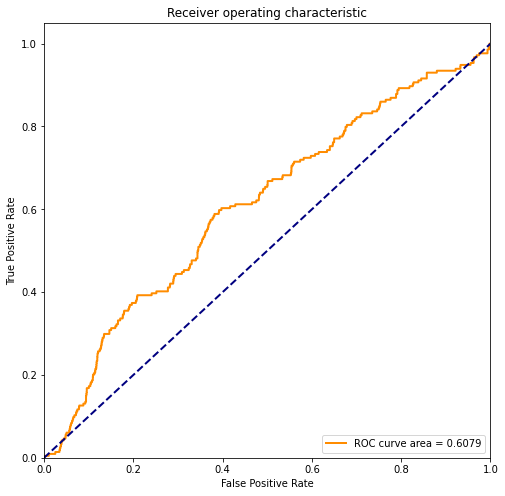

In [93]:
TPRi, FPRi, thresholds_i = roc_curve(hdf['HOSP_OUTCOME'], hdf['RISK_SCORE'], pos_label=None, sample_weight=None, drop_intermediate=True)
plotroc(TPRi, FPRi)

In [23]:
hdf['HOSP_OUTCOME'].sum()/hdf.shape[0]

0.09183673469387756